# Analysis on a second set of data

We have taken data from another site and from others leagues as Turkey, Belgium, and others and we did the same test as for the original ones.

So basically here there is no forecast so we can only exploit results and results_away and no xPoints or xG because there were no data about forecast.

Replicability factor changes :

- Another datasets
- Period longer than the original study

In [1]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy.stats as stats
import numpy as np
from IPython.display import display


In [2]:
leagues = ['T1', 'B1', 'G1', 'N1', 'P1'] 
# List of leagues, T1 = Turkey, B1 = Belgium, G1 = Greece, N1 = Netherlands, P1 = Portugal
# 1 is for the first division of the league

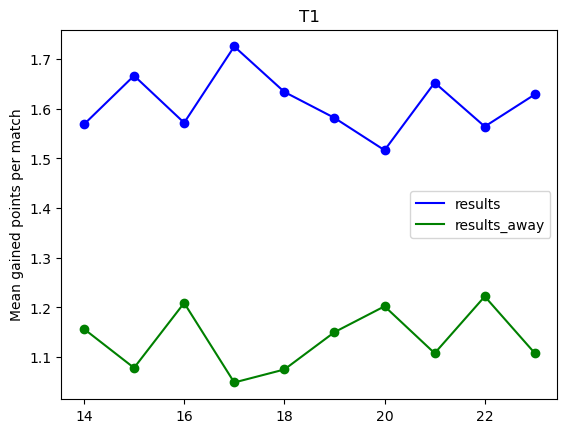

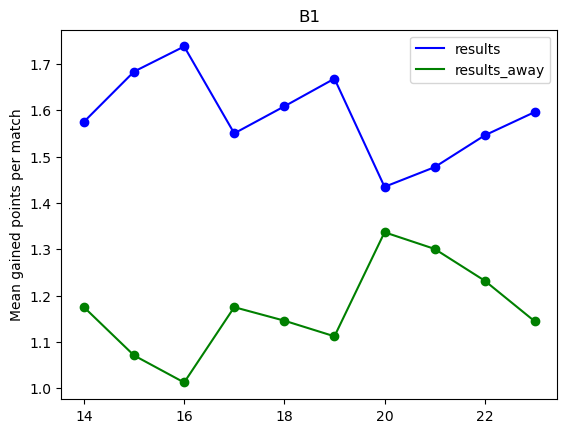

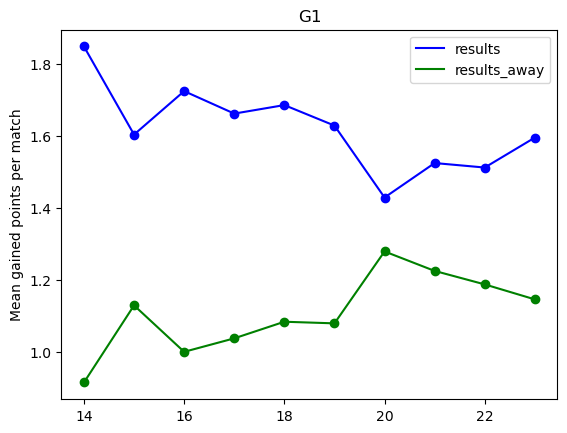

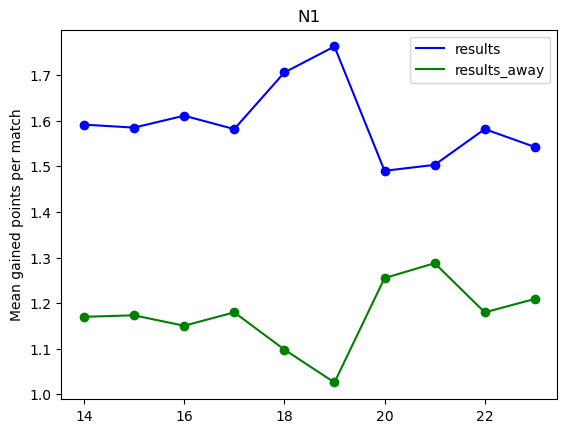

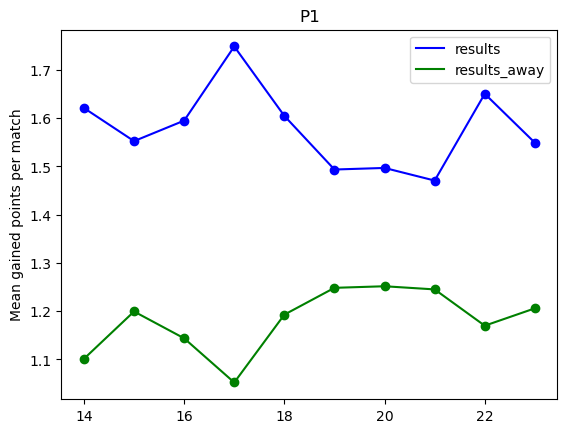

In [8]:
def create_graph(league):
    data = pd.read_csv(os.path.join('other_data_leagues', league + '.csv'))
    # Calculer les points attendus (xP) pour domicile et extérieur
    data['results'] = 0  # Initialiser
    data['results_away'] = 0  # Initialiser

    data.loc[data['FTR'] == 'H', 'results'] = 3
    data.loc[data['FTR'] == 'D', 'results'] = 1

    data.loc[data['FTR'] == 'A', 'results_away'] = 3
    data.loc[data['FTR'] == 'D', 'results_away'] = 1


    # Calculer la moyenne de xP pour les équipes à domicile et à l'extérieur par saison
    average_results = data.groupby('year')['results'].mean()
    average_results_away = data.groupby('year')['results_away'].mean()

    #Création graphe
    fig, ax = plt.subplots()
    plt.title(league)
    ax.plot(average_results.index, average_results, color="blue", label="results")
    ax.scatter(average_results.index, average_results, color="blue", marker="o")
    ax.plot(average_results_away.index, average_results_away, color="green", label="results_away")
    ax.scatter(average_results_away.index, average_results_away, color="green", marker="o")

    plt.ylabel("Mean gained points per match")
    plt.legend(fontsize=10)
    plt.show()
for league in leagues:
    create_graph(league)

In [13]:
def diff_points(leagues):
    df_leagues = pd.DataFrame()
    df_results = pd.DataFrame()
    for league in leagues:
        data = pd.read_csv(os.path.join('other_data_leagues', league + '.csv'))
        data['results'] = 0  # Initialiser
        data['results_away'] = 0  # Initialiser

        data.loc[data['FTR'] == 'H', 'results'] = 3
        data.loc[data['FTR'] == 'D', 'results'] = 1

        data.loc[data['FTR'] == 'A', 'results_away'] = 3
        data.loc[data['FTR'] == 'D', 'results_away'] = 1
        data['league'] = league
        data['year'] = data['year']

        df_results = pd.concat([df_results, data[['league', 'year', 'results', 'results_away']]], ignore_index=True)

        results_home = data.groupby('year')['results'].sum()
        results_away = data.groupby('year')['results_away'].sum()
        
        df = pd.DataFrame()
        df["diff_points"] = results_home - results_away
        df["league"] = league
        df["year"] = df.index
        df.reset_index(drop=True, inplace=True)
        df_leagues = pd.concat([df_leagues, df], ignore_index=True)

    df_leagues.set_index('league', inplace=True)
    df_leagues.set_index('year', append=True, inplace=True)
    return df_leagues, df_results

def style_formatter(leagues):
    df_leagues,_ = diff_points(leagues)
    return df_leagues.style \
    .format(precision=0, thousands=".", decimal=",") \
    .format_index(str.upper, axis=1) \
    .bar(subset= ["diff_points"], color = ['#b0351a', '#069215'], align=0, vmin=df_leagues["diff_points"].min(), vmax=df_leagues["diff_points"].max(), height=60,
         width=80, props="width: 200px; border-right: 1px solid black;")

display(style_formatter(leagues))

In [14]:
def cohen_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    
    mean1, mean2 = np.mean(group1), np.mean(group2)
    std1, std2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    s_pooled = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))
    
    d = (mean1 - mean2) / s_pooled
    return d

def perform_statistical_tests_on_results(df):
    results = []
    grouped = df.groupby('league')
    for league, group in grouped:
        for year in group['year'].unique():
            subset = group[group['year'] == year]
            if len(subset) < 2:  
                continue
            
            home_results = subset['results']
            away_results = subset['results_away']
            
            wilco_result, wilco_result_pvalue = stats.wilcoxon(home_results, away_results)

            results.append({
                'league': league,
                'year': year,
                'wilco-result': wilco_result,
                'wilco-result-pvalue': wilco_result_pvalue,
                'result-cohend': cohen_d(home_results, away_results),
            })
    
    results_df = pd.DataFrame(results)
    return results_df

def style_formatter_proba(dataframe):
    # Fonction pour la coloration conditionnelle

    def color_wilco(val):
        color = 'red' if val > 0.05 else ''
        return f'color: {color};'
    
    def color_cohend(val):
        color = '#F4C430' if val < 0.2 else ''
        return f'background-color: {color}'

    def zebra_style(row_index):
        return "background-color: #f8f9fa;" if row_index % 2 == 0 else "background-color: white;"


    # Application du style combiné
    return (
        dataframe.style
        .format(precision=2, decimal=",")
        .format_index(str.upper, axis=1)
        # Appliquer une alternance de couleurs sur les lignes (zebra-striping)
        .apply(lambda row: [zebra_style(row.name)] * len(dataframe.columns), axis=1)
        # Texte noir par défaut
        .set_properties(**{"color": "black", "font-family": "Times New Roman", "font-size": "1.3em"})
        .map(color_wilco, subset=["wilco-result-pvalue"])
        .map(color_cohend, subset=["result-cohend"])
    )

_, df_leagues = diff_points(leagues)
results_df = perform_statistical_tests_on_results(df_leagues)
style_formatter_proba(results_df)

,LEAGUE,YEAR,WILCO-RESULT,WILCO-RESULT-PVALUE,RESULT-COHEND
0,B1,14,"6697,00","0,02","0,31"
1,B1,15,"6006,00","0,00","0,48"
2,B1,16,"5520,50","0,00","0,57"
3,B1,17,"6300,00","0,02","0,29"
4,B1,18,"6552,00","0,01","0,36"
5,B1,19,"6279,00","0,00","0,42"
6,B1,20,"13390,50","0,52","0,07"
7,B1,21,"13145,00","0,24","0,13"
8,B1,22,"12308,50","0,04","0,24"
9,B1,23,"10672,00","0,00","0,35"


In [17]:
def mann_whitney_u_test_on_seasons(df):
    results = []
    
    for league, group in df.groupby('league'):
        years = group['year'].unique()
        
        for i in range(len(years)):
            for j in range(i + 1, len(years)):
                year_1 = years[i]
                year_2 = years[j]
                
                data_1 = group[group['year'] == year_1]['results']
                data_2 = group[group['year'] == year_2]['results']
                
                stat, p_value = stats.mannwhitneyu(data_1, data_2)
                
                results.append({
                    'league': league,
                    'year_1': year_1,
                    'year_2': year_2,
                    'p_value': p_value
                })
    results_df = pd.DataFrame(results)
    return results_df



# Fonction de style conditionnel
def highlight_pval(val):
    if val == "":  # Ignorer les cellules vides
        return ''
    elif isinstance(val, (float, int)) and val < 0.05:  # P-values significatives
        return 'color: red; font-weight: bold;'
    else:
        return 'color: black;'



results_df = mann_whitney_u_test_on_seasons(df_leagues)
for league, group in results_df.groupby('league'):
    pivot_df = group.pivot(index='year_2', columns='year_1', values='p_value')
    pivot_df.columns.name = None  # Supprime le nom de l'index des colonnes
    pivot_df.index.name = None  # Supprime le nom de l'index des lignes
    pivot_df = pivot_df.fillna("")
    # Appliquer le style
    styled_df = pivot_df.style.map(highlight_pval)
    styled_df = (
        pivot_df.style
        .map(highlight_pval)  # Appliquer le style conditionnel
        .set_table_styles(
            [
                {'selector': 'th', 'props': 'border: 1px solid black; font-weight: bold;'},
                {'selector': 'td', 'props': 'border: 1px solid black;'}
            ]
        )
    )
    print(f"{league} resultHome change significance with Mann") 
    display(styled_df)

B1 resultHome change significance with Mann


,14,15,16,17,18,19,20,21,22
15,0.363397,,,,,,,,
16,0.166297,0.637624,,,,,,,
17,0.889324,0.287061,0.121391,,,,,,
18,0.786861,0.524573,0.267230,0.678557,,,,,
19,0.484639,0.853850,0.520061,0.397185,0.664061,,,,
20,0.186542,0.023681,0.005788,0.230155,0.109914,0.044894,,,
21,0.336156,0.057366,0.016627,0.403821,0.215185,0.097907,0.710941,,
22,0.728452,0.197473,0.074745,0.834577,0.530699,0.288891,0.309554,0.520642,
23,0.826052,0.451030,0.207146,0.708893,0.943992,0.593218,0.097539,0.204762,0.545320


G1 resultHome change significance with Mann


,14,15,16,17,18,19,20,21,22
15,0.030143,,,,,,,,
16,0.280438,0.287314,,,,,,,
17,0.107477,0.554873,0.619850,,,,,,
18,0.139298,0.543066,0.672786,0.961086,,,,,
19,0.055334,0.778432,0.423470,0.754404,0.729756,,,,
20,0.000231,0.153597,0.011802,0.039030,0.044927,0.081789,,,
21,0.003851,0.469708,0.075389,0.185517,0.192243,0.310402,0.500887,,
22,0.003292,0.487370,0.073637,0.187704,0.194365,0.319124,0.450172,0.956591,
23,0.024304,0.925450,0.249340,0.494593,0.486528,0.707461,0.185996,0.531446,0.552540


N1 resultHome change significance with Mann


,14,15,16,17,18,19,20,21,22
15,0.958843,,,,,,,,
16,0.852274,0.811482,,,,,,,
17,0.925983,0.967079,0.779967,,,,,,
18,0.336848,0.311120,0.435516,0.293429,,,,,
19,0.149015,0.135333,0.202723,0.126634,0.598523,,,,
20,0.363936,0.391097,0.272857,0.415841,0.064219,0.022445,,,
21,0.352259,0.377946,0.265873,0.401419,0.065523,0.023992,0.957998,,
22,0.925983,0.967079,0.779967,1.000000,0.293429,0.126634,0.415841,0.401419,
23,0.664287,0.701848,0.534084,0.733711,0.165258,0.064779,0.634732,0.608671,0.733711


P1 resultHome change significance with Mann


,14,15,16,17,18,19,20,21,22
15,0.449725,,,,,,,,
16,0.761938,0.652525,,,,,,,
17,0.303720,0.085389,0.192749,,,,,,
18,0.704657,0.730993,0.929965,0.182564,,,,,
19,0.193716,0.598392,0.324388,0.025133,0.392292,,,,
20,0.198028,0.604360,0.329741,0.026205,0.397759,0.995323,,,
21,0.148508,0.513016,0.261458,0.016674,0.324725,0.906100,0.901626,,
22,0.997636,0.480122,0.775820,0.339338,0.721727,0.225754,0.230120,0.178610,
23,0.425255,0.966383,0.622744,0.078908,0.700994,0.629270,0.635208,0.542493,0.456424


T1 resultHome change significance with Mann


,14,15,16,17,18,19,20,21,22
15,0.372061,,,,,,,,
16,0.879707,0.314260,,,,,,,
17,0.169120,0.620701,0.142349,,,,,,
18,0.489864,0.823821,0.414663,0.468000,,,,,
19,0.915988,0.432928,0.800963,0.205250,0.561791,,,,
20,0.603124,0.139953,0.737748,0.047263,0.203281,0.527659,,,
21,0.457960,0.853770,0.385367,0.486802,0.966221,0.528580,0.178252,,
22,0.802471,0.261196,0.927287,0.111226,0.351816,0.724226,0.809630,0.322717,
23,0.562089,0.718539,0.474938,0.380873,0.893350,0.640824,0.238323,0.856474,0.404839
